# COVID-19 Composition Model

In [1]:
using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

Define functions ϕ of flows in the SEIRH model

In [2]:
fNewIncidence(u,p,t)=p.β*u.S*u.I/p.N
fNewInfectious(u,p,t)=u.E*p.ri
fNewRecovery(u,p,t)=u.I/p.tr * (1.0-p.fH )
fWaningImmunityR(u,p,t)=u.R/p.tw
fHICUAdmission(u,p,t) = u.I/p.tr * p.fH * p.fICU
fHNICUAdmission(u,p,t) = u.I/p.tr * p.fH * (1.0-p.fICU)
fOutICU(u,p,t) = u.HICU/p.tICU
fRecoveryH(u,p,t)= u.HNICU/p.tH

fRecoveryH (generic function with 1 method)

StockAndFlowp(stocks,
              (flow=>function, upstream=>downstream) => stocks linked)

In [3]:
seirh = StockAndFlowp((:S, :E, :I, :R, :HICU, :HNICU),
   ((:NewIncidence=>fNewIncidence, :S=>:E) => (:S, :I),
    (:NewInfectious=>fNewInfectious, :E=>:I) => :E,
    (:NewRecovery=>fNewRecovery, :I=>:R) => :I,
    (:WaningImmunityR=>fWaningImmunityR, :R=>:S) => :R,
    (:HICUAdmission=>fHICUAdmission, :I=>:HICU) => :I,
    (:HNICUAdmission=>fHNICUAdmission, :I=>:HNICU) => :I,
    (:OutICU=>fOutICU, :HICU=>:HNICU) => :HICU,
    (:RecoveryH=>fRecoveryH, :HNICU=>:R) => :HNICU))

StockAndFlowp {Flow:8, Stock:6, Link:9, Name:0, FuncFlow:0}
┌──────┬───┬───┬─────────────────┬──────────────────┐
│ Flow │ u │ d │           fname │               ϕf │
├──────┼───┼───┼─────────────────┼──────────────────┤
│    1 │ 1 │ 2 │    NewIncidence │    fNewIncidence │
│    2 │ 2 │ 3 │   NewInfectious │   fNewInfectious │
│    3 │ 3 │ 4 │     NewRecovery │     fNewRecovery │
│    4 │ 4 │ 1 │ WaningImmunityR │ fWaningImmunityR │
│    5 │ 3 │ 5 │   HICUAdmission │   fHICUAdmission │
│    6 │ 3 │ 6 │  HNICUAdmission │  fHNICUAdmission │
│    7 │ 5 │ 6 │          OutICU │          fOutICU │
│    8 │ 6 │ 4 │       RecoveryH │       fRecoveryH │
└──────┴───┴───┴─────────────────┴──────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │     R │
│     5 │  HICU │
│     6 │ HNICU │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 3 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 3 │ 3 │
│    5 │ 4 │ 4 │
│    6 │ 3 │ 5 │
│    7 │ 3 │ 6 │
│    8 │ 5 │ 7 │
│    9 │ 6 │ 8 │
└──────┴───┴───┘

Graph(primitive stock-flow model, direction of the diagram - the default value is "LR" from left to right;
users could also use "TB" from top to bottom)
Graph(seirh)

Define functions ϕ of flows in the Vaccine model

In [4]:
fFirstdoseVaccine(u,p,t) = u.S * p.rv
fSeconddoseVaccine(u,p,t) = u.VP * p.rv
fWaningImmunityVP(u,p,t) = u.VP / p.tw
fWaningImmunityVF(u,p,t) = u.VF / p.tw
fNewIncidenceVP(u,p,t) = p.β*u.VP*u.I*(1.0-p.eP)/p.N
fNewIncidenceVF(u,p,t) = p.β*u.VF*u.I*(1.0-p.eF)/p.N

fNewIncidenceVF (generic function with 1 method)

Stock and flow diagram of Vaccine model

In [5]:
v = StockAndFlowp((:S, :E, :I, :VP, :VF),
   ((:FirstdoseVaccine=>fFirstdoseVaccine, :S=>:VP) => :S,
    (:SeconddoseVaccine=>fSeconddoseVaccine, :VP=>:VF) => :VP,
    (:WaningImmunityVP=>fWaningImmunityVP, :VP=>:S) => :VP,
    (:WaningImmunityVF=>fWaningImmunityVF, :VF=>:VP) => :VF,
    (:NewIncidenceVP=>fNewIncidenceVP, :VP=>:E) => (:VP, :I),
    (:NewIncidenceVF=>fNewIncidenceVF, :VF=>:E) => (:VF, :I)))

StockAndFlowp {Flow:6, Stock:5, Link:8, Name:0, FuncFlow:0}
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 4 │  FirstdoseVaccine │  fFirstdoseVaccine │
│    2 │ 4 │ 5 │ SeconddoseVaccine │ fSeconddoseVaccine │
│    3 │ 4 │ 1 │  WaningImmunityVP │  fWaningImmunityVP │
│    4 │ 5 │ 4 │  WaningImmunityVF │  fWaningImmunityVF │
│    5 │ 4 │ 2 │    NewIncidenceVP │    fNewIncidenceVP │
│    6 │ 5 │ 2 │    NewIncidenceVF │    fNewIncidenceVF │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │    VP │
│     5 │    VF │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 4 │ 2 │
│    3 │ 4 │ 3 │
│    4 │ 5 │ 4 │
│    5 │ 4 │ 5 │
│    6 │ 3 │ 5 │
│    7 │ 5 │ 6 │
│    8 │ 3 │ 6 │
└──────┴───┴───┘

Graph(v,"TB")

Define functions ϕ of flows in the Persist Asymptomaticity model

In [6]:
fNewPersistentAsymptomaticity(u,p,t) = u.E * p.ria
fNewRecoveryIA(u,p,t) = u.IA / p.tr

fNewRecoveryIA (generic function with 1 method)

Stock and flow diagram of Persistent Asymptomaticity Model

In [7]:
ia = StockAndFlowp((:E, :IA, :R),
   ((:NewPersistentAsymptomaticity=>fNewPersistentAsymptomaticity, :E=>:IA) => :E,
    (:NewRecoveryIA=>fNewRecoveryIA, :IA=>:R) => :IA))

StockAndFlowp {Flow:2, Stock:3, Link:2, Name:0, FuncFlow:0}
┌──────┬───┬───┬──────────────────────────────┬───────────────────────────────┐
│ Flow │ u │ d │                        fname │                            ϕf │
├──────┼───┼───┼──────────────────────────────┼───────────────────────────────┤
│    1 │ 1 │ 2 │ NewPersistentAsymptomaticity │ fNewPersistentAsymptomaticity │
│    2 │ 2 │ 3 │                NewRecoveryIA │                fNewRecoveryIA │
└──────┴───┴───┴──────────────────────────────┴───────────────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     E │
│     2 │    IA │
│     3 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 2 │
└──────┴───┴───┘

Graph(ia)

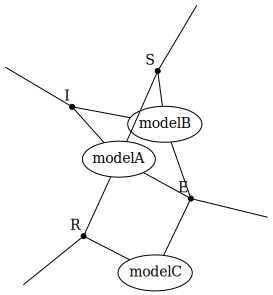

In [8]:
covid = @relation (S, E, I, R) begin
    modelA(S,E,I,R)
    modelB(S,E,I)
    modelC(E,R)
end;
display_uwd(covid)

Open three Stock and Flow Diagrams

In [9]:
openseirh = Open(seirh, [:S], [:E], [:I], [:R])
openv = Open(v, [:S], [:E], [:I])
openia = Open(ia, [:E], [:R])

Catlab.CategoricalAlgebra.StructuredCospans.StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{ACSets.DenseACSets.AnonACSet{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:Stock}, Tuple{}, Tuple{:Name, :FuncFlow}, Tuple{(:sname, :Stock, :Name)}}, Tuple{Symbol, Function}, NamedTuple{(:Stock, :Name, :FuncFlow), Tuple{ACSets.DenseACSets.IntParts, ACSets.DenseACSets.IntParts, ACSets.DenseACSets.IntParts}}, NamedTuple{(:sname,), Tuple{ACSets.ColumnImplementations.DenseColumn{Union{ACSets.ColumnImplementations.AttrVar, Symbol}, Vector{Union{ACSets.ColumnImplementations.AttrVar, Symbol}}}}}, ACSets.DenseACSets.IntParts}, StockAndFlowp}, Catlab.CategoricalAlgebra.FreeDiagrams.Multicospan{StockAndFlowp, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:Flow, :Stock, :Link}, Tuple{(:u, :Flow, :Stock), (:d, :Flow, :Stock), (:s, :Link, :Stock), (:t, :Link, :Flow)}, Tuple{:Name, :FuncFlow}, Tuple{(:sname, :St

Compose those three models according the UWD-algebra

In [10]:
openCOVID19 = oapply(covid, [openseirh, openv, openia])

Catlab.CategoricalAlgebra.StructuredCospans.StructuredMulticospan{Catlab.CategoricalAlgebra.StructuredCospans.DiscreteACSet{ACSets.DenseACSets.AnonACSet{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:Stock}, Tuple{}, Tuple{:Name, :FuncFlow}, Tuple{(:sname, :Stock, :Name)}}, Tuple{Symbol, Function}, NamedTuple{(:Stock, :Name, :FuncFlow), Tuple{ACSets.DenseACSets.IntParts, ACSets.DenseACSets.IntParts, ACSets.DenseACSets.IntParts}}, NamedTuple{(:sname,), Tuple{ACSets.ColumnImplementations.DenseColumn{Union{ACSets.ColumnImplementations.AttrVar, Symbol}, Vector{Union{ACSets.ColumnImplementations.AttrVar, Symbol}}}}}, ACSets.DenseACSets.IntParts}, StockAndFlowp}, Catlab.CategoricalAlgebra.FreeDiagrams.Multicospan{StockAndFlowp, Catlab.CategoricalAlgebra.CSets.StructTightACSetTransformation{ACSets.Schemas.TypeLevelBasicSchema{Symbol, Tuple{:Flow, :Stock, :Link}, Tuple{(:u, :Flow, :Stock), (:d, :Flow, :Stock), (:s, :Link, :Stock), (:t, :Link, :Flow)}, Tuple{:Name, :FuncFlow}, Tuple{(:sname

Generate the composed model (Stock and Flow Diagram)

In [11]:
COVID19 = apex(openCOVID19)

Flow,u,d,fname,ϕf
1,1,2,NewIncidence,fNewIncidence
2,2,3,NewInfectious,fNewInfectious
3,3,4,NewRecovery,fNewRecovery
4,4,1,WaningImmunityR,fWaningImmunityR
5,3,5,HICUAdmission,fHICUAdmission
6,3,6,HNICUAdmission,fHNICUAdmission
7,5,6,OutICU,fOutICU
8,6,4,RecoveryH,fRecoveryH
9,1,7,FirstdoseVaccine,fFirstdoseVaccine
10,7,8,SeconddoseVaccine,fSeconddoseVaccine


Graph(COVID19)

Define constant parameters

In [12]:
p_COVID19 = LVector(
    β=0.8, N=38010001.0, tr=12.22, tw=2*365.0,
    fH=0.002, fICU=0.23, tICU=6.0, tH = 12.0,
    rv=0.01, eP=0.6, eF=0.85, ri=0.207, ria=0.138
)

13-element LabelledArrays.LArray{Float64, 1, Vector{Float64}, (:β, :N, :tr, :tw, :fH, :fICU, :tICU, :tH, :rv, :eP, :eF, :ri, :ria)}:
    :β => 0.8
    :N => 3.8010001e7
   :tr => 12.22
   :tw => 730.0
   :fH => 0.002
 :fICU => 0.23
       ⋮
   :rv => 0.01
   :eP => 0.6
   :eF => 0.85
   :ri => 0.207
  :ria => 0.138

Define initial values for stocks

In [13]:
u0_COVID19 = LVector(
    S=38010000.0, E=0.0, I=1.0, IA=0.0, R=0.0, HICU=0.0, HNICU=0.0, VP=0.0, VF=0.0
)

9-element LabelledArrays.LArray{Float64, 1, Vector{Float64}, (:S, :E, :I, :IA, :R, :HICU, :HNICU, :VP, :VF)}:
     :S => 3.801e7
     :E => 0.0
     :I => 1.0
    :IA => 0.0
     :R => 0.0
  :HICU => 0.0
 :HNICU => 0.0
    :VP => 0.0
    :VF => 0.0

Check the dependencies of links of all flows' functions
checkfls(COVID19, u0_COVID19, p_COVID19)

Solve the ODEs

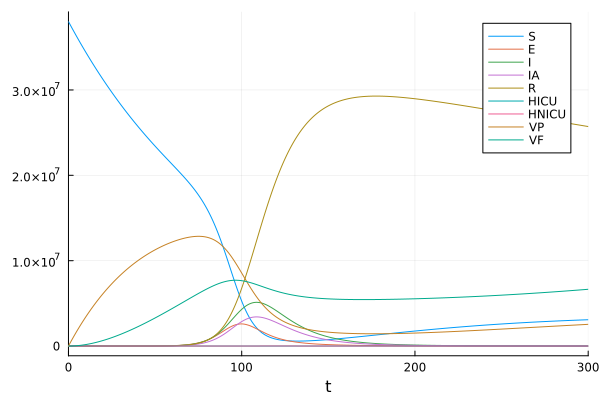

In [14]:
prob_COVID19 = ODEProblem(vectorfield(COVID19),u0_COVID19,(0.0,300.0),p_COVID19);
sol_COVID19 = solve(prob_COVID19,Tsit5(),abstol=1e-8);
plot(sol_COVID19)

Flow of ```FirstdoseVaccine```

In [15]:
ϕFirstdoseVaccine = map(x->fFirstdoseVaccine(sol_COVID19.u[x],p_COVID19,sol_COVID19.t[x]),collect(1:length(sol_COVID19.t)))

73-element Vector{Float64}:
 380100.0
 380099.9999998586
 380099.9999984444
 380099.9999843023
 380099.99984288134
 380099.9984286719
 380099.98428657756
 380099.84286566736
 380098.4286598555
 380084.28693077463
      ⋮
  24993.703401041785
  25975.60729815375
  26896.20401314409
  27755.495774897558
  28553.881697610963
  29292.12814658216
  29971.342663084168
  30592.946906482044
  30842.07913220906